In [1]:
from torch.optim.swa_utils import get_ema_multi_avg_fn
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import make_grid
from tqdm import trange
import torch

from main import Model, NoiseScheduler, DATASETS, denormalize, CONFIGS, parse_args, ACTIVATION_FUNCTIONS

In [14]:
device = torch.device('cuda:7')
model_path = '/home/ubuntu/diffusion-from-scratch/results/celebA-64/model.pth'

In [15]:
config = CONFIGS['celeba-64']
args = parse_args(args=config)
args

Namespace(activation='silu', attention_resolutions=[16], batch_size=64, channel_mult=[1, 1, 2, 2, 4, 4], command='train', conditional=False, config=None, dataset='celeba', dropout=0.0, ema_decay=0.9999, epochs=2000, file_path='img.png', gpu=None, grad_accum=1, grad_clip=1.0, hflip=True, log_interval=5, lr=2e-05, model='model.pth', model_channels=128, num_res_blocks=2, output_dir='output', progress=True, resolution=64, save_checkpoints=True, steps=500000, val_interval=1000, warmup=5000)

In [16]:
dataset = DATASETS[args.dataset]
dataset

Dataset(name='celeba', cls=functools.partial(<class 'main.CelebAHQ'>, root='./data/CelebAMask-HQ'), image_channels=3, resolution=1024, num_classes=40)

In [17]:
noise_scheduler = NoiseScheduler().to(device)

In [18]:
model = Model(image_channels=dataset.image_channels,
              model_channels=args.model_channels,
              activation_fn=ACTIVATION_FUNCTIONS[args.activation],
              num_res_blocks=args.num_res_blocks,
              channel_mult=args.channel_mult,
              dropout=args.dropout,
              attention_resolutions=args.attention_resolutions,
              num_classes=dataset.num_classes,
              conditional=args.conditional)
#ema_decay = args.ema_decay
#model = torch.optim.swa_utils.AveragedModel(model, multi_avg_fn=get_ema_multi_avg_fn(ema_decay))
model.load_state_dict(torch.load(model_path, weights_only=True))
model = model.to(device)

In [7]:
torch.manual_seed(0)
resolution = args.resolution or dataset.resolution

torch.manual_seed(1)
x1 = torch.randn(1, dataset.image_channels, resolution, resolution, device=device)
z1 = torch.randn(noise_scheduler.steps, 1, dataset.image_channels, resolution, resolution, device=device)
torch.manual_seed(2)
x2 = torch.randn(1, dataset.image_channels, resolution, resolution, device=device)
z2 = torch.randn(noise_scheduler.steps, 1, dataset.image_channels, resolution, resolution, device=device)

# Interpolate between x1 and x2
a = torch.linspace(0, 1, 256).to(device)
x = torch.cat([i * x1 + (1 - i) * x2 for i in a], dim=0)
z = torch.cat([i * z1 + (1 - i) * z2 for i in a], dim=1)

steps = trange(noise_scheduler.steps - 1, -1, -1)
for step in steps:
    with torch.no_grad():
        t = torch.tensor(step, device=device).expand(x.size(0), )
        pred_noise = model(x, t)
        x = noise_scheduler.sample_prev_step(x, t, pred_noise, z[step])

x = denormalize(x).clamp(0, 1)
grid = make_grid(x, nrow=16)
img = to_pil_image(grid)

  4%|▍         | 44/1000 [00:08<02:54,  5.49it/s]


KeyboardInterrupt: 

In [ ]:
img

In [ ]:
img.save('interpolation.png')

In [19]:
resolution = args.resolution or dataset.resolution
n = 16

torch.manual_seed(0)
x1 = torch.randn(1, dataset.image_channels, resolution, resolution, device=device)
z1 = torch.randn(noise_scheduler.steps, 1, dataset.image_channels, resolution, resolution, device=device)
x = []
z = []
for seed in trange(1, n+1):
    if seed < n:
        torch.manual_seed(seed)
        x2 = torch.randn(1, dataset.image_channels, resolution, resolution, device=device)
        z2 = torch.randn(noise_scheduler.steps, 1, dataset.image_channels, resolution, resolution, device=device)
    else:
        x2 = x[0]
        z2 = z[0]

    # Interpolate between x1 and x2
    a = torch.linspace(0, 1, n+1)
    x += [(1-i) * x1 + i * x2 for i in a][:-1]
    z += [(1-i) * z1 + i * z2 for i in a][:-1]

    x1 = x2
    z1 = z2

x = torch.cat(x, dim=0)
z = torch.cat(z, dim=1)

steps = trange(noise_scheduler.steps - 1, -1, -1)
for step in steps:
    with torch.no_grad():
        t = torch.tensor(step, device=device).expand(x.size(0), )
        pred_noise = model(x, t)
        x = noise_scheduler.sample_prev_step(x, t, pred_noise, z[step])

out = denormalize(x).clamp(0, 1).cpu()

grid = make_grid(out, nrow=n)
img = to_pil_image(grid)

100%|██████████| 1000/1000 [02:53<00:00,  5.76it/s]


In [21]:
resolution = args.resolution or dataset.resolution
n = 16

torch.manual_seed(0)
x1 = torch.randn(1, dataset.image_channels, resolution, resolution)
z1 = torch.randn(noise_scheduler.steps, 1, dataset.image_channels, resolution, resolution)
x = []
z = []
for seed in trange(1, n+1):
    if seed < n:
        torch.manual_seed(seed)
        x2 = torch.randn(1, dataset.image_channels, resolution, resolution)
        z2 = torch.randn(noise_scheduler.steps, 1, dataset.image_channels, resolution, resolution)
    else:
        x2 = x[0]
        z2 = z[0]

    # Interpolate between x1 and x2
    a = torch.linspace(0, 1, n+1)
    x += [(1-i) * x1 + i * x2 for i in a][:-1]
    z += [(1-i) * z1 + i * z2 for i in a][:-1]

    x1 = x2
    z1 = z2

x = torch.cat(x, dim=0)
z = torch.cat(z, dim=1)

out = []
batch_size = 256
for i in range(0, x.size(0), batch_size):
    x_batch = x[i:i+batch_size].to(device)
    z_batch = z[:, i:i+batch_size].to(device)
    steps = trange(noise_scheduler.steps - 1, -1, -1)
    for step in steps:
        with torch.no_grad():
            t = torch.tensor(step, device=device).expand(x_batch.size(0), )
            pred_noise = model(x_batch, t)
            x_batch = noise_scheduler.sample_prev_step(x_batch, t, pred_noise, z_batch[step])

    x_batch = denormalize(x_batch).clamp(0, 1).cpu()
    out.append(x_batch)
out = torch.cat(out, dim=0)

grid = make_grid(out, nrow=n)
img = to_pil_image(grid)

100%|██████████| 1000/1000 [02:53<00:00,  5.76it/s]


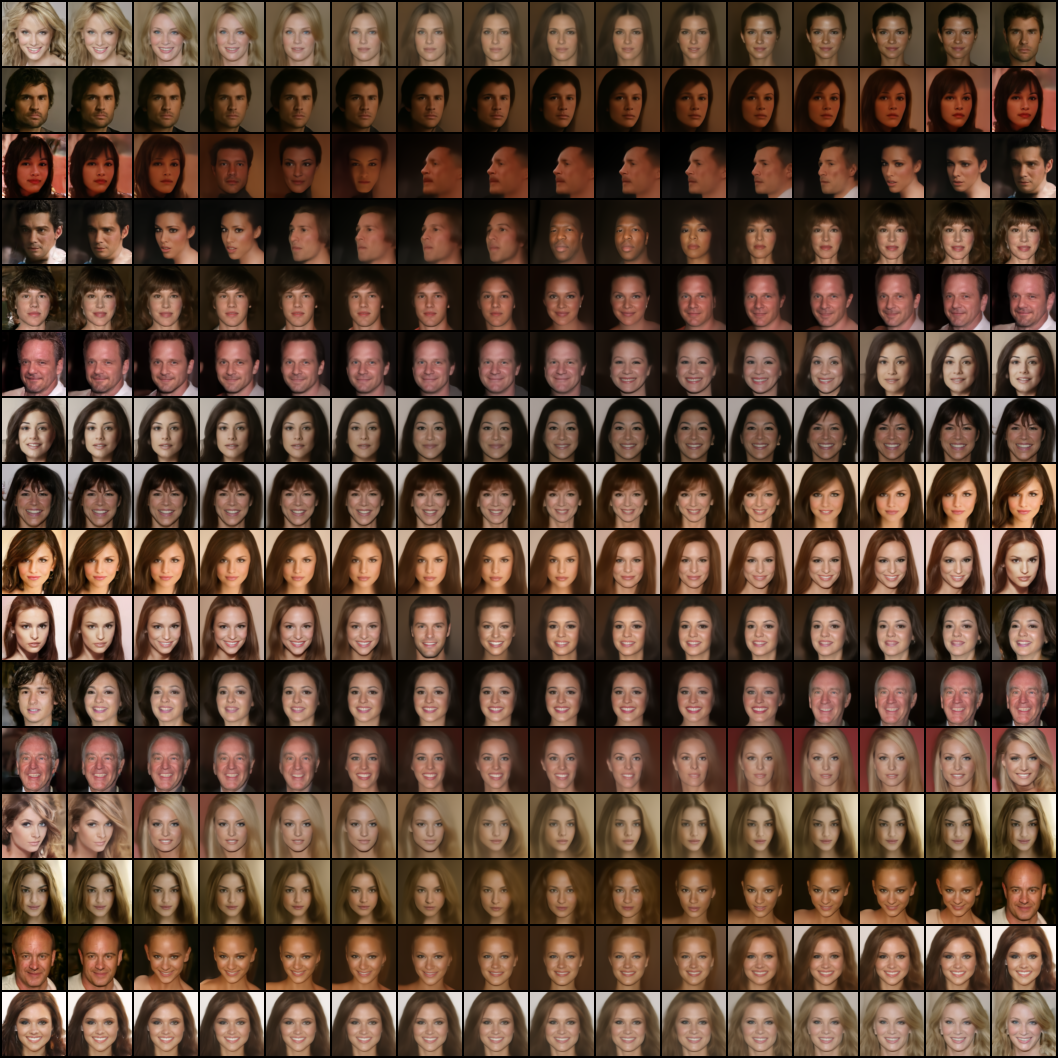

In [20]:
img

In [21]:
!pip install ipywidgets

from PIL import Image
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, Play, HBox, VBox, jslink
import matplotlib.pyplot as plt
import numpy as np

def animate_images(image_list, display_size=(400, 400)):
    """
    Creates an IPython widget to animate a list of PIL images with play and slider controls.
    Args:
        image_list (list of PIL.Image.Image): List of PIL images to animate.
        display_size (tuple): Display size in pixels (width, height).
    """
    # Convert display size from pixels to inches for Matplotlib (DPI = 100)
    figsize = (display_size[0] / 100, display_size[1] / 100)

    # Ensure all images are in a NumPy-compatible format for Matplotlib
    image_arrays = [np.array(image) for image in image_list]

    # Function to display a specific frame
    def display_frame(frame):
        plt.figure(figsize=figsize)
        plt.imshow(image_arrays[frame], interpolation='nearest')
        plt.axis("off")
        plt.show()

    # Create slider and play widgets
    slider = IntSlider(value=0, min=0, max=len(image_list) - 1, step=1, description="Frame")
    play = Play(value=0, min=0, max=len(image_list) - 1, step=1, interval=200, description="Press Play")

    # Link play and slider
    jslink((play, "value"), (slider, "value"))

    # Display the interactive widget
    interact(display_frame, frame=slider)
    return HBox([play, slider])

images = [to_pil_image(xi) for xi in out]
animate_images(images, (1024, 1024))

interactive(children=(IntSlider(value=0, description='Frame', max=255), Output()), _dom_classes=('widget-inter…

In [13]:
output_path, duration, loop = 'interp.gif', 200, True
images[0].save(
    output_path,
    save_all=True,
    append_images=images[1:],
    duration=duration,
    loop=loop,
)
print(f"GIF saved at {output_path}")

GIF saved at interp.gif
